In [27]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from transformers import pipeline
from nltk.tokenize import sent_tokenize
from src.scripts.sentiment_analysis import *
import math
from scipy import stats
from collections import defaultdict
from src.scripts.linear_regression import *
import json
from sklearn.preprocessing import StandardScaler

In [28]:
with open('data/genre_categories.json', 'r') as f:
    genre_categories = json.load(f)
data = create_regression_dataset(genre_categories)

In [29]:
df = pd.read_csv('data/linear_regression_data.csv')
df.columns

Index(['wikipedia_id', 'BookRating', 'MovieRuntime', 'MovieRating',
       'MovieBoxOffice', 'MovieRatingNb', 'MovieGenre', 'neg', 'neu', 'pos',
       'compound', 'polarity', 'subjectivity', 'sadness', 'joy', 'love',
       'anger', 'fear', 'surprise', 'EnglishLanguage', 'FrenchLanguage',
       'GermanLanguage', 'SpanishLanguage', 'ActionAdventure', 'Comedy',
       'CrimeGangster', 'Drama', 'FamilyChildren', 'FantasyScienceFiction',
       'HistoricalPeriod', 'HorrorSupernatural', 'OtherGenre',
       'RomanceRelationship', 'ThrillersMysteries'],
      dtype='object')

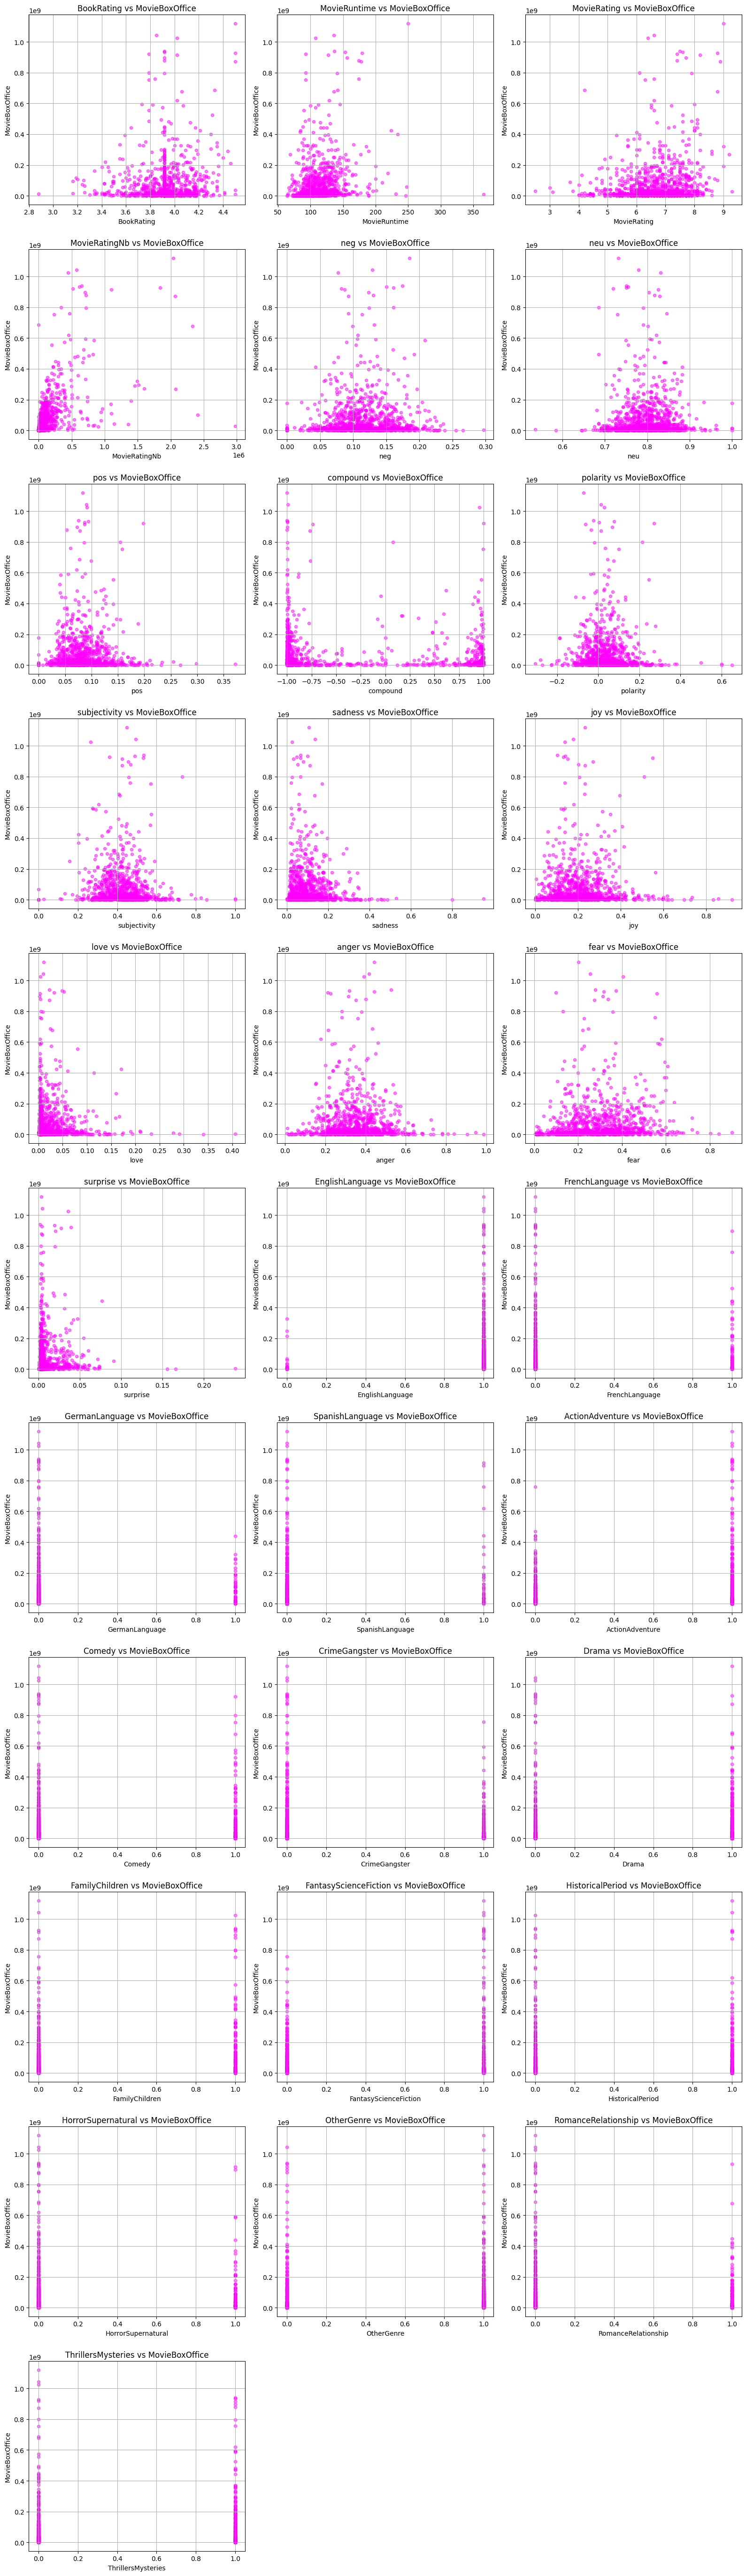

In [30]:
exploratory_plot(df, 'MovieBoxOffice')

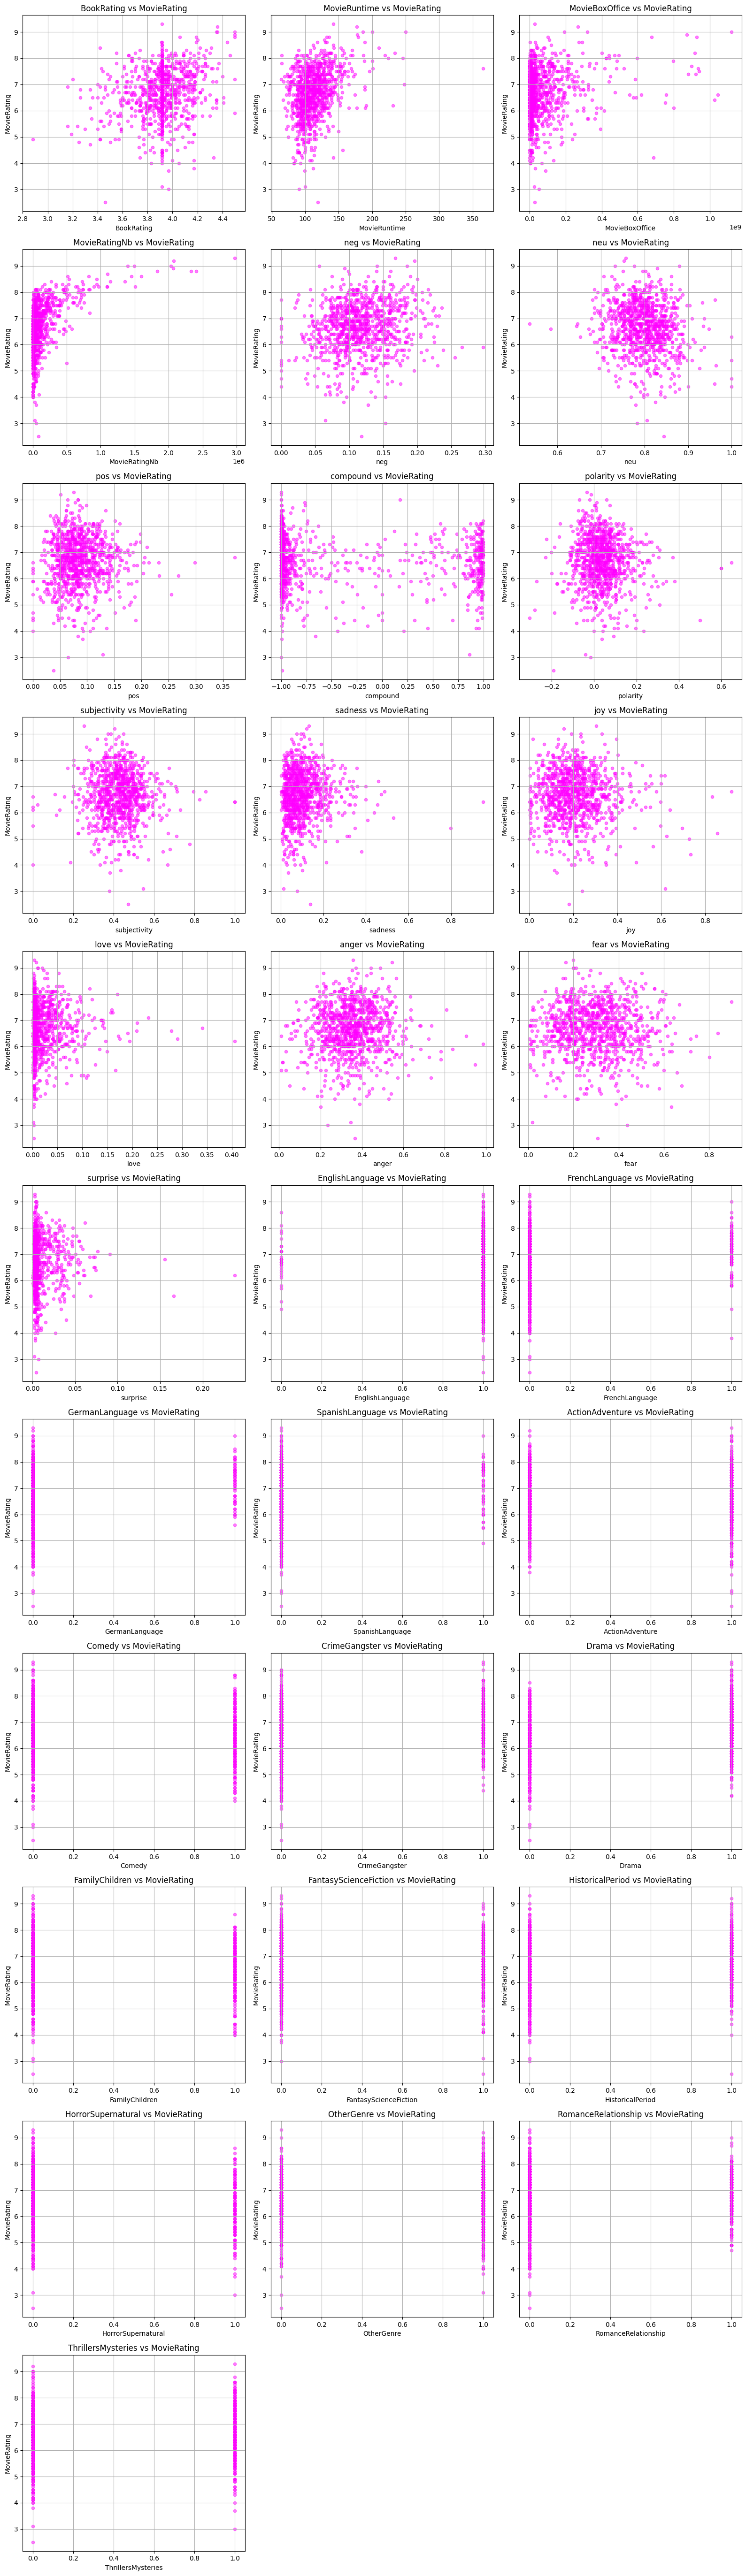

In [31]:
exploratory_plot(df, 'MovieRating')

**Note:**

By plotting movie box office against our features, it seems that it has a somewhat heavy tailed distribution.

It doesn't seem to be the case for movie rating.

### Regression on Box Office

#### Basic regression on box office with all features

In [32]:
df_boxoffice = df.copy()

#scaler = StandardScaler()
#col_to_stand = ['BookRating', 'MovieRuntime', 'MovieRatingNb','neg', 'neu', 'pos', 'compound', 'polarity', 'subjectivity','sadness', 'joy', 'love', 'fear', 'anger', 'surprise']
#df_boxoffice[col_to_stand] = scaler.fit_transform(df_boxoffice[col_to_stand])

# as we want to predict ahead of time, we remove rating information from movie
df_boxoffice.drop(columns = ['MovieGenre', 'MovieRatingNb', 'MovieRating'], inplace=True)

target = 'MovieBoxOffice'
features = [col for col in df_boxoffice.columns.tolist() if (col != target and col != 'wikipedia_id')]
formula = f"{target} ~ {' + '.join(features)}"

model = train_linear_regression(df_boxoffice, formula)

                            OLS Regression Results                            
Dep. Variable:         MovieBoxOffice   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     9.842
Date:                Fri, 20 Dec 2024   Prob (F-statistic):           1.15e-37
Time:                        22:13:42   Log-Likelihood:                -19901.
No. Observations:                 991   AIC:                         3.986e+04
Df Residuals:                     961   BIC:                         4.001e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              7.617e+

**Note:**
The condition number is still large however it isn't anymore if you standardize the data which indicates that it is not a multicolinearity issue. We have decided not to standardize it in order to maintain interpretability

#### Regression on log of box office with all features

In [33]:
df_boxoffice = df.copy()
df_boxoffice['MovieBoxOfficeLog'] = np.log(df_boxoffice.MovieBoxOffice)
# as we want to predict ahead of time, we remove rating information from movie
df_boxoffice.drop(columns = ['MovieGenre', 'MovieRatingNb', 'MovieRating', 'MovieBoxOffice'], inplace=True)

target = 'MovieBoxOfficeLog'
features = [col for col in df_boxoffice.columns.tolist() if (col != target and col != 'wikipedia_id')]
formula = f"{target} ~ {' + '.join(features)}"

model = train_linear_regression(df_boxoffice, formula)

                            OLS Regression Results                            
Dep. Variable:      MovieBoxOfficeLog   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     12.56
Date:                Fri, 20 Dec 2024   Prob (F-statistic):           2.12e-49
Time:                        22:13:42   Log-Likelihood:                -1860.0
No. Observations:                 991   AIC:                             3780.
Df Residuals:                     961   BIC:                             3927.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -3.222e+

**Note:**
Our intuition was right as R^squared improved by taking the log of the box office.

#### Forward selection to pick relevant and impactful features

In [34]:
target = 'MovieBoxOfficeLog'
features = [col for col in df_boxoffice.columns.tolist() if (col != target and col != 'wikipedia_id')]
selected_features = forward_selection(df_boxoffice, target, features)
print("Forward Selected Features:", selected_features)


Selected MovieRuntime with AIC 3979.3261109780497
Selected FantasyScienceFiction with AIC 3905.302847261273
Selected ThrillersMysteries with AIC 3859.021357389202
Selected FamilyChildren with AIC 3808.2748583429725
Selected Comedy with AIC 3795.3999971939725
Selected Drama with AIC 3784.0301774030695
Selected EnglishLanguage with AIC 3778.439345158975
Selected RomanceRelationship with AIC 3773.246537759697
Selected sadness with AIC 3767.444318296698
Selected SpanishLanguage with AIC 3764.8939355687658
Selected HistoricalPeriod with AIC 3762.137559477836
Selected subjectivity with AIC 3759.703058473673
Selected fear with AIC 3759.470460210252
Selected ActionAdventure with AIC 3759.458333843913
Forward Selected Features: ['MovieRuntime', 'FantasyScienceFiction', 'ThrillersMysteries', 'FamilyChildren', 'Comedy', 'Drama', 'EnglishLanguage', 'RomanceRelationship', 'sadness', 'SpanishLanguage', 'HistoricalPeriod', 'subjectivity', 'fear', 'ActionAdventure']


#### Final linear regression 

                            OLS Regression Results                            
Dep. Variable:      MovieBoxOfficeLog   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.257
Method:                 Least Squares   F-statistic:                     25.51
Date:                Fri, 20 Dec 2024   Prob (F-statistic):           6.04e-57
Time:                        22:13:49   Log-Likelihood:                -1864.7
No. Observations:                 991   AIC:                             3759.
Df Residuals:                     976   BIC:                             3833.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                12.86

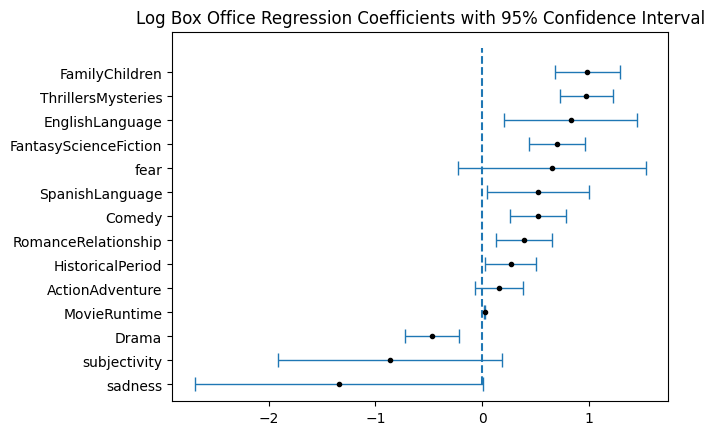

In [35]:
target = 'MovieBoxOfficeLog'
features = selected_features
formula = f"{target} ~ {' + '.join(features)}"

model = train_linear_regression(df_boxoffice, formula)

with open("log_boxoffice_rating_summary.txt", "w") as file:
    file.write(model.summary().as_text())

title = 'Log Box Office Regression Coefficients with 95% Confidence Interval'
plot_coefficients(model, title)

### Regression on movie rating

#### Basic regression on box office with all features

In [36]:
df_rating = df.copy()

#scaler = StandardScaler()
#col_to_stand = ['BookRating', 'MovieRuntime', 'MovieRatingNb','neg', 'neu', 'pos', 'compound', 'polarity', 'subjectivity','sadness', 'joy', 'love', 'fear', 'anger', 'surprise']
#df_rating[col_to_stand] = scaler.fit_transform(df_rating[col_to_stand])

# as we want to predict ahead of time, we remove rating information from movie
df_rating.drop(columns = ['MovieGenre', 'MovieBoxOffice', 'MovieRatingNb'], inplace=True)

target = 'MovieRating'
features = [col for col in df_rating.columns.tolist() if (col != target and col != 'wikipedia_id')]
formula = f"{target} ~ {' + '.join(features)}"

model = train_linear_regression(df_rating, formula)

                            OLS Regression Results                            
Dep. Variable:            MovieRating   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     14.39
Date:                Fri, 20 Dec 2024   Prob (F-statistic):           5.03e-57
Time:                        22:13:50   Log-Likelihood:                -1165.2
No. Observations:                 991   AIC:                             2390.
Df Residuals:                     961   BIC:                             2537.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -1.537e+

#### Regression on log of box office with all features

In [37]:
df_rating = df.copy()
df_rating['MovieRatingLog'] = np.log(df_rating.MovieRating)
# as we want to predict ahead of time, we remove rating information from movie
df_rating.drop(columns = ['MovieGenre', 'MovieBoxOffice', 'MovieRating', 'MovieRatingNb'], inplace=True)

target = 'MovieRatingLog'
features = [col for col in df_rating.columns.tolist() if (col != target and col != 'wikipedia_id')]
formula = f"{target} ~ {' + '.join(features)}"

model = train_linear_regression(df_rating, formula)

                            OLS Regression Results                            
Dep. Variable:         MovieRatingLog   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     13.19
Date:                Fri, 20 Dec 2024   Prob (F-statistic):           4.59e-52
Time:                        22:13:50   Log-Likelihood:                 629.73
No. Observations:                 991   AIC:                            -1199.
Df Residuals:                     961   BIC:                            -1052.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -2.501e+

**Note:**
We keep movie rating as it has the best R^squared value

#### Forward selection to pick features

In [38]:
df_rating = df.copy()
df_rating.drop(columns = ['MovieGenre', 'MovieBoxOffice', 'MovieRatingNb'], inplace=True)
target = 'MovieRating'
features = [col for col in df_rating.columns.tolist() if (col != target and col != 'wikipedia_id')]
selected_features = forward_selection(df_rating, target, features)
print("Forward Selected Features:", selected_features)

Selected MovieRuntime with AIC 2570.5874629216773
Selected Drama with AIC 2491.364805847557
Selected BookRating with AIC 2445.654874668144
Selected OtherGenre with AIC 2428.2313689804287
Selected neg with AIC 2412.477921937566
Selected FrenchLanguage with AIC 2396.7338776808447
Selected CrimeGangster with AIC 2390.4907064720514
Selected HorrorSupernatural with AIC 2385.8344212664833
Selected FantasyScienceFiction with AIC 2380.4882269908385
Selected SpanishLanguage with AIC 2376.904036696814
Selected GermanLanguage with AIC 2374.609494473283
Selected neu with AIC 2371.8779478122206
Selected surprise with AIC 2370.2172840033645
Selected compound with AIC 2369.7064556128626
Selected ActionAdventure with AIC 2369.440287072305
Forward Selected Features: ['MovieRuntime', 'Drama', 'BookRating', 'OtherGenre', 'neg', 'FrenchLanguage', 'CrimeGangster', 'HorrorSupernatural', 'FantasyScienceFiction', 'SpanishLanguage', 'GermanLanguage', 'neu', 'surprise', 'compound', 'ActionAdventure']


#### Final linear regression 

                            OLS Regression Results                            
Dep. Variable:            MovieRating   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     27.55
Date:                Fri, 20 Dec 2024   Prob (F-statistic):           9.78e-65
Time:                        22:13:56   Log-Likelihood:                -1168.7
No. Observations:                 991   AIC:                             2369.
Df Residuals:                     975   BIC:                             2448.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 3.44

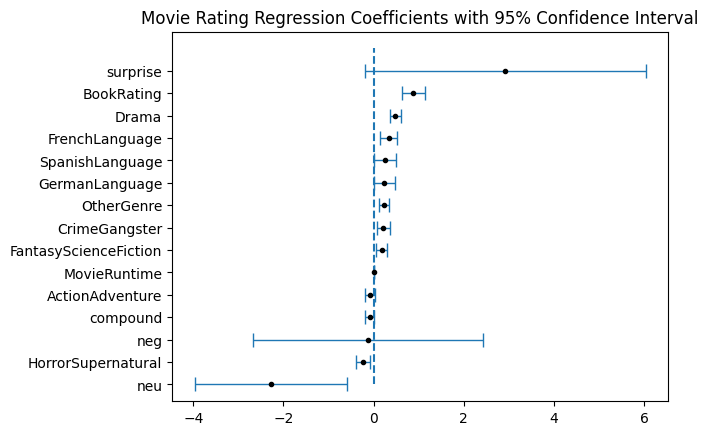

In [39]:
target = 'MovieRating'
features = selected_features
formula = f"{target} ~ {' + '.join(features)}"

model = train_linear_regression(df_rating, formula)
with open("regression_rating_summary.txt", "w") as file:
    file.write(model.summary().as_text())
    
title = 'Movie Rating Regression Coefficients with 95% Confidence Interval'
plot_coefficients(model, title)